In [2]:
# Install kagglehub for easy Kaggle dataset access
!pip install -q kagglehub

# NLP and ML basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# NLP cleaning
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

# Load and clean the dataset
df = pd.read_csv(path + '/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['clean_message'] = df['message'].apply(clean_text)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})


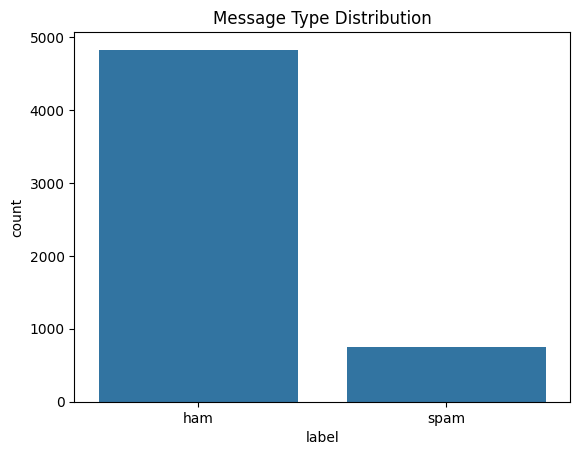

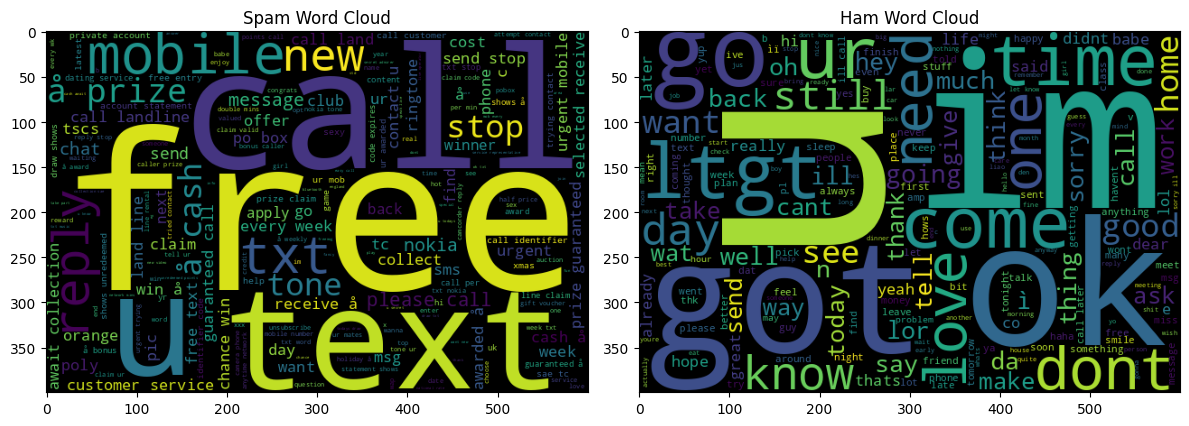

In [5]:
# Spam vs Ham count
sns.countplot(data=df, x='label')
plt.title("Message Type Distribution")
plt.show()

# Word cloud (optional)
from wordcloud import WordCloud

spam_words = " ".join(df[df['label'] == 'spam']['clean_message'])
ham_words = " ".join(df[df['label'] == 'ham']['clean_message'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=600, height=400).generate(spam_words))
plt.title("Spam Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=600, height=400).generate(ham_words))
plt.title("Ham Word Cloud")

plt.tight_layout()
plt.show()


In [6]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_message'])
y = df['label_num']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.63      0.76       150

    accuracy                           0.95      1115
   macro avg       0.95      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115



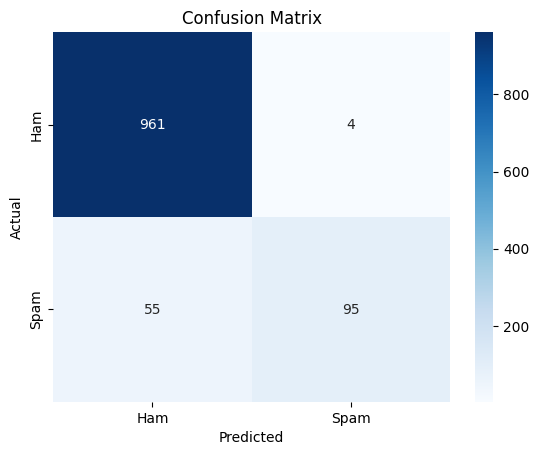

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
!pip install -q xgboost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       965
           1       0.95      0.85      0.89       150

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [15]:
def predict_message(text, model=model, vectorizer=vectorizer):
    # Clean the input text using the same cleaning function
    clean = clean_text(text)
    vec = vectorizer.transform([clean])
    prediction = model.predict(vec)[0]
    label = 'SPAM' if prediction == 1 else 'HAM'
    return f"🔍 Prediction: {label}"

# Example test messages
print(predict_message("Congratulations! You've won a free iPhone. Claim now!"))
print(predict_message("Hey, are we still meeting for dinner tonight?"))

# Try your own
your_message = "Hey, just checking in to see how your day’s going."
print(predict_message(your_message))


🔍 Prediction: SPAM
🔍 Prediction: HAM
🔍 Prediction: HAM


In [14]:
predict_message(text="Urgent! Your account is at risk. Verify info.", model=xgb_model)


'🔍 Prediction: HAM'

In [16]:
for word in ['urgent', 'account', 'verify', 'risk']:
    print(f"{word} in vocab:", word in vectorizer.vocabulary_)


urgent in vocab: True
account in vocab: True
verify in vocab: True
risk in vocab: True


In [17]:
# Add new synthetic spam samples
new_data = pd.DataFrame({
    'label': ['spam'] * 5,
    'message': [
        "Urgent! Your account is at risk. Verify now.",
        "Immediate action required. Confirm your password to avoid lock.",
        "Suspicious login detected. Click to verify your identity.",
        "Account breach alert! Check your info now.",
        "This is your final warning! Account security compromised."
    ]
})
new_data['clean_message'] = new_data['message'].apply(clean_text)
new_data['label_num'] = 1

# Append to original dataset
df_augmented = pd.concat([df, new_data], ignore_index=True)


In [18]:
# Vectorize new data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_augmented['clean_message'])
y = df_augmented['label_num']


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


🔍 Logistic Regression Classification Report (After Retraining):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       961
           1       0.99      0.65      0.79       155

    accuracy                           0.95      1116
   macro avg       0.97      0.83      0.88      1116
weighted avg       0.95      0.95      0.95      1116



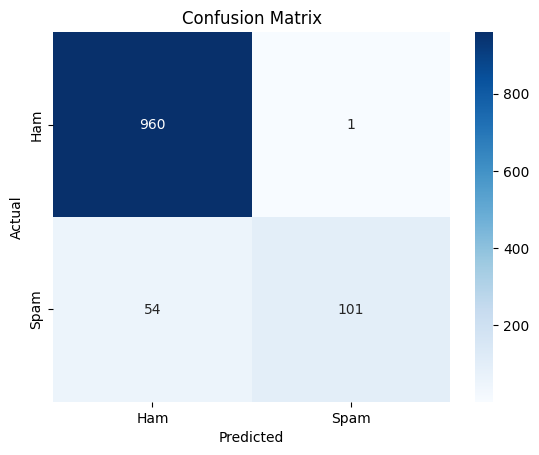

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("🔍 Logistic Regression Classification Report (After Retraining):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
predict_message("Urgent! Your account is at risk. Verify info.")


'🔍 Prediction: HAM'

In [23]:
!pip install -q transformers

from transformers import pipeline

# Load a sentiment classification pipeline (can work surprisingly well for spam-style inputs)
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

def classify_with_bert(message):
    result = classifier(message)[0]
    label = result['label']
    score = round(result['score'], 3)
    return f"🤖 BERT Prediction: {label} ({score})"

# Test it
print(classify_with_bert("Urgent! Your account is at risk. Verify info."))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


🤖 BERT Prediction: NEGATIVE (0.992)


In [24]:
def predict_message(text, use_bert=False):
    if use_bert:
        return classify_with_bert(text)
    else:
        clean = clean_text(text)
        vec = vectorizer.transform([clean])
        prediction = model.predict(vec)[0]
        label = 'SPAM' if prediction == 1 else 'HAM'
        return f"🔍 TF-IDF Prediction: {label}"


In [25]:
print(predict_message("Urgent! Your account is at risk. Verify info.", use_bert=True))


🤖 BERT Prediction: NEGATIVE (0.992)


In [26]:
from ipywidgets import widgets, VBox, HBox
from IPython.display import display, clear_output, HTML
import pandas as pd

# Store predictions for analysis
prediction_log = []

# Text input
input_box = widgets.Text(
    value='',
    placeholder='Type a message here...',
    description='📩 Message:',
    layout=widgets.Layout(width='100%')
)

# Dropdown to select model
model_dropdown = widgets.Dropdown(
    options=['TF-IDF Model', 'BERT'],
    value='TF-IDF Model',
    description='🧠 Model:',
)

# Output display
output_area = widgets.Output()

# Predict button
predict_button = widgets.Button(
    description='Detect Scam 🚨',
    button_style='danger',
    layout=widgets.Layout(width='30%')
)

# Emoji-enhanced display
def styled_prediction(label, score=None):
    if label.lower() in ['spam', 'negative']:
        emoji = "🚨"
        color = "#ff4c4c"
        label = "⚠️ SPAM / SCAM"
    else:
        emoji = "✅"
        color = "#2ecc71"
        label = "✅ HAM / Safe Message"

    style = f"""
    <div style='
        background-color:{color};
        padding:10px;
        border-radius:10px;
        color:white;
        font-size:16px;
        text-align:center;
        font-weight:bold;
        margin-top:10px;
    '>{emoji} {label}</div>
    """
    return HTML(style)

# Prediction logic
def on_predict_clicked(b):
    with output_area:
        clear_output()
        msg = input_box.value
        model_choice = model_dropdown.value

        if model_choice == 'TF-IDF Model':
            raw_result = predict_message(msg, use_bert=False)
            label = 'spam' if 'SPAM' in raw_result else 'ham'
        else:
            result = classifier(msg)[0]
            label = result['label'].lower()
            score = round(result['score'], 3)
            raw_result = f"{label.upper()} ({score})"

        # Save to log
        prediction_log.append({
            'Message': msg,
            'Model': model_choice,
            'Prediction': label.upper(),
            'Raw Output': raw_result
        })

        # Show styled prediction
        display(styled_prediction(label, score))

# Attach function to button
predict_button.on_click(on_predict_clicked)

# Display the app
display(VBox([input_box, model_dropdown, predict_button, output_area]))
